#### About
This algorithm creates matches between people who have higher score of having a good enough relationship.

In [184]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/0

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFE, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_curve, accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from scipy import stats
import seaborn as sns
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io.arff import loadarff


In [185]:
raw_data = loadarff('datasets/speeddating.arff')
df = pd.DataFrame(raw_data[0])


In [186]:
df.shape

(8378, 123)

In [187]:
df.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,b'0',1.0,b'female',21.0,27.0,6.0,b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',...,b'[0-3]',b'[3-5]',7.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'0',b'0'
1,b'0',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',...,b'[0-3]',b'[3-5]',7.0,5.0,b'[6-8]',b'[5-6]',1.0,b'1',b'0',b'0'
2,b'1',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'Asian/Pacific Islander/Asian-American',b'1',...,b'[0-3]',b'[3-5]',7.0,NaN,b'[6-8]',b'[0-4]',1.0,b'1',b'1',b'1'
3,b'0',1.0,b'female',21.0,23.0,2.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',...,b'[0-3]',b'[3-5]',7.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'1',b'1'
4,b'0',1.0,b'female',21.0,24.0,3.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'Latino/Hispanic American',b'0',...,b'[0-3]',b'[3-5]',6.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'1',b'1'


In [188]:
df.has_null.unique()

array([b'0', b'1'], dtype=object)

In [189]:
# drop columns with no contribution
df.drop('has_null', axis = 1, inplace = True)

In [190]:
df.select_dtypes(include='object')

,gender,d_d_age,race,race_o,samerace,d_importance_same_race,d_importance_same_religion,field,d_pref_o_attractive,d_pref_o_sincere,...,d_yoga,d_interests_correlate,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,d_like,d_guess_prob_liked,decision,decision_o,match
0,b'female',b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',b'[2-5]',b'[2-5]',b'Law',b'[21-100]',b'[16-20]',...,b'[0-5]',b'[0-0.33]',b'[0-4]',b'[0-3]',b'[3-5]',b'[6-8]',b'[5-6]',b'1',b'0',b'0'
1,b'female',b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',b'[2-5]',b'[2-5]',b'Law',b'[21-100]',b'[0-15]',...,b'[0-5]',b'[0.33-1]',b'[0-4]',b'[0-3]',b'[3-5]',b'[6-8]',b'[5-6]',b'1',b'0',b'0'
2,b'female',b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'Asian/Pacific Islander/Asian-American',b'1',b'[2-5]',b'[2-5]',b'Law',b'[16-20]',b'[16-20]',...,b'[0-5]',b'[0-0.33]',b'[0-4]',b'[0-3]',b'[3-5]',b'[6-8]',b'[0-4]',b'1',b'1',b'1'
3,b'female',b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',b'[2-5]',b'[2-5]',b'Law',b'[21-100]',b'[0-15]',...,b'[0-5]',b'[0.33-1]',b'[0-4]',b'[0-3]',b'[3-5]',b'[6-8]',b'[5-6]',b'1',b'1',b'1'
4,b'female',b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'Latino/Hispanic American',b'0',b'[2-5]',b'[2-5]',b'Law',b'[21-100]',b'[0-15]',...,b'[0-5]',b'[0-0.33]',b'[0-4]',b'[0-3]',b'[3-5]',b'[6-8]',b'[5-6]',b'1',b'1',b'1'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,b'male',b'[0-1]',b'European/Caucasian-American',b'Latino/Hispanic American',b'0',b'[0-1]',b'[0-1]',b'Climate Dynamics',b'[0-15]',b'[0-15]',...,b'[0-5]',b'[0.33-1]',b'[7-10]',b'[0-3]',b'[3-5]',b'[0-5]',b'[5-6]',b'0',b'1',b'0'
8374,b'male',b'[0-1]',b'European/Caucasian-American',b'Other',b'0',b'[0-1]',b'[0-1]',b'Climate Dynamics',b'[21-100]',b'[16-20]',...,b'[0-5]',b'[0.33-1]',b'[7-10]',b'[0-3]',b'[3-5]',b'[0-5]',b'[0-4]',b'0',b'0',b'0'
8375,b'male',b'[4-6]',b'European/Caucasian-American',b'Latino/Hispanic American',b'0',b'[0-1]',b'[0-1]',b'Climate Dynamics',b'[21-100]',b'[0-15]',...,b'[0-5]',b'[-1-0]',b'[7-10]',b'[0-3]',b'[3-5]',b'[6-8]',b'[5-6]',b'0',b'0',b'0'
8376,b'male',b'[2-3]',b'European/Caucasian-American',b'Asian/Pacific Islander/Asian-American',b'0',b'[0-1]',b'[0-1]',b'Climate Dynamics',b'[0-15]',b'[21-100]',...,b'[0-5]',b'[0.33-1]',b'[7-10]',b'[0-3]',b'[3-5]',b'[0-5]',b'[5-6]',b'0',b'1',b'0'


In [191]:
#convert object classes into ordinal codes
for col in df.columns:
    if df[col].dtype == "object" :
        oe = OrdinalEncoder()
        oe.fit(df[[col]])
        df[col] = oe.fit_transform(df[[col]])

In [192]:
df['d_attractive_important']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8373    2.0
8374    2.0
8375    2.0
8376    2.0
8377    2.0
Name: d_attractive_important, Length: 8378, dtype: float64

In [193]:
df.head()

,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,1.0,0.0,21.0,27.0,6.0,2.0,1.0,3.0,0.0,2.0,...,0.0,1.0,7.0,6.0,1.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,21.0,22.0,1.0,0.0,1.0,3.0,0.0,2.0,...,0.0,1.0,7.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0
2,1.0,0.0,21.0,22.0,1.0,0.0,1.0,1.0,1.0,2.0,...,0.0,1.0,7.0,NaN,1.0,0.0,1.0,1.0,1.0,1.0
3,1.0,0.0,21.0,23.0,2.0,1.0,1.0,3.0,0.0,2.0,...,0.0,1.0,7.0,6.0,1.0,1.0,0.0,1.0,1.0,1.0
4,1.0,0.0,21.0,24.0,3.0,1.0,1.0,4.0,0.0,2.0,...,0.0,1.0,6.0,6.0,1.0,1.0,0.0,1.0,1.0,1.0


In [194]:
df.dropna().shape

(1048, 122)

In [195]:
null_counts = df.isnull().sum()

for column, null_count in null_counts.items():
    if null_count > 0:
        print(f"{column} : {null_count}")

age : 95
age_o : 104
importance_same_race : 79
importance_same_religion : 79
pref_o_attractive : 89
pref_o_sincere : 89
pref_o_intelligence : 89
pref_o_funny : 98
pref_o_ambitious : 107
pref_o_shared_interests : 129
attractive_o : 212
sinsere_o : 287
intelligence_o : 306
funny_o : 360
ambitous_o : 722
shared_interests_o : 1076
attractive_important : 79
sincere_important : 79
intellicence_important : 79
funny_important : 89
ambtition_important : 99
shared_interests_important : 121
attractive : 105
sincere : 105
intelligence : 105
funny : 105
ambition : 105
attractive_partner : 202
sincere_partner : 277
intelligence_partner : 296
funny_partner : 350
ambition_partner : 712
shared_interests_partner : 1067
sports : 79
tvsports : 79
exercise : 79
dining : 79
museums : 79
art : 79
hiking : 79
gaming : 79
clubbing : 79
reading : 79
tv : 79
theater : 79
movies : 79
concerts : 79
music : 79
shopping : 79
yoga : 79
interests_correlate : 158
expected_happy_with_sd_people : 101
expected_num_interes

In [196]:
#drop columns have more than 100 null values and drop the rows with majority column data missing
columns_to_drop = [column for column, null_count in null_counts.items() if null_count > 1000]
columns_to_drop
df = df.drop(columns=columns_to_drop)

In [197]:
#imputing remaining null values with median
null_counts_revised = df.isnull().sum()

for column, null_count in null_counts_revised.items():
    if null_count > 0:
        print(f"{column}: {null_count}")
        median_value = df[column].median()
        df[column].fillna(median_value, inplace=True)

age: 95
age_o: 104
importance_same_race: 79
importance_same_religion: 79
pref_o_attractive: 89
pref_o_sincere: 89
pref_o_intelligence: 89
pref_o_funny: 98
pref_o_ambitious: 107
pref_o_shared_interests: 129
attractive_o: 212
sinsere_o: 287
intelligence_o: 306
funny_o: 360
ambitous_o: 722
attractive_important: 79
sincere_important: 79
intellicence_important: 79
funny_important: 89
ambtition_important: 99
shared_interests_important: 121
attractive: 105
sincere: 105
intelligence: 105
funny: 105
ambition: 105
attractive_partner: 202
sincere_partner: 277
intelligence_partner: 296
funny_partner: 350
ambition_partner: 712
sports: 79
tvsports: 79
exercise: 79
dining: 79
museums: 79
art: 79
hiking: 79
gaming: 79
clubbing: 79
reading: 79
tv: 79
theater: 79
movies: 79
concerts: 79
music: 79
shopping: 79
yoga: 79
interests_correlate: 158
expected_happy_with_sd_people: 101
like: 240
guess_prob_liked: 309
met: 375


In [198]:
df.isna().sum()

wave                  0
gender                0
age                   0
age_o                 0
d_age                 0
                     ..
d_guess_prob_liked    0
met                   0
decision              0
decision_o            0
match                 0
Length: 118, dtype: int64

In [199]:
df.shape

(8378, 118)

In [200]:
duplicate_rows = df.duplicated()
# check if any duplicates exist
if duplicate_rows.any():
    # print the duplicate row
    print(df[duplicate_rows])
else:
    print("No duplicates found.")

No duplicates found.


In [201]:
# Prepare the features(X) and the target (y)
X = df.drop(["match"], axis = 1) # Replace "target_column" with the actual column name
y = df['match']

In [202]:
# our target variable
df['match']

0       0.0
1       0.0
2       1.0
3       1.0
4       1.0
       ... 
8373    0.0
8374    0.0
8375    0.0
8376    0.0
8377    0.0
Name: match, Length: 8378, dtype: float64

In [203]:
# Make sure we have the right values in the target variable
print("Unique values in 'match' column:", y.unique())

Unique values in 'match' column: [0. 1.]


In [204]:
print("Target variable distribution:")
print(y.value_counts(normalize=True))

Target variable distribution:
0.0    0.835283
1.0    0.164717
Name: match, dtype: float64


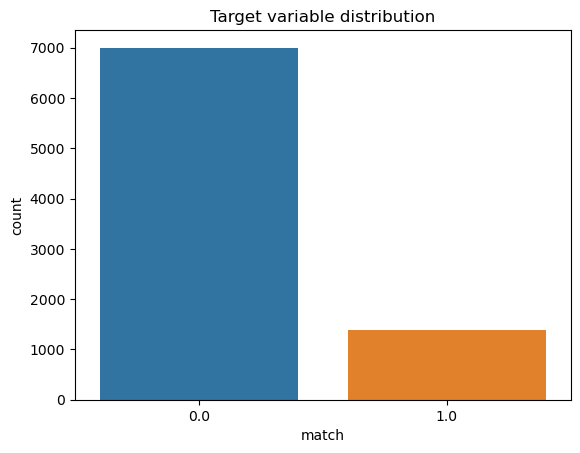

In [205]:
# Plot the distribution of the target variable
sns.countplot(x=y)
plt.title("Target variable distribution")
plt.show()


In [206]:
corr_matrix = df.corr()
print("Correction with the target variable:")
print(corr_matrix['match'].sort_values(ascending=False))

Correction with the target variable:
match                         1.000000
decision_o                    0.522326
decision                      0.521943
like                          0.305302
d_like                        0.284972
                                ...   
pref_o_shared_interests      -0.047953
shared_interests_important   -0.047959
importance_same_race         -0.048932
d_importance_same_race       -0.049741
d_d_age                      -0.058097
Name: match, Length: 118, dtype: float64


In [207]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [208]:
# calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y = y_train)

# Create a logistic regression model with class weighs
lr = LogisticRegression(solver='liblinear', penalty='12', C = 0.1, class_weight= {0: class_weights[0], 1: class_weights[1]} )

In [209]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring = 'f1_macro')

# Print cross-validation scores and average
print("Cross-validation F1-scores:", cv_scores)
print("Average F1-score:", np.mean(cv_scores))

Cross-validation F1-scores: [nan nan nan nan nan]
Average F1-score: nan


c:\Users\PC USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\PC USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\PC USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\PC USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 441, in _check_solver
    raise ValueError(